## Overview

The purpose of this kernel is to take a look at the data, come up with some insights, and attempt to create a predictive model or two. This notebook is still **very** raw - the first few EDA sections have been decently explored/formatted, but the latter predictive sections are completely uncommented. I hope to work on those as my, very limited, time permits.

## Packages

First, let's load a few useful Python packages. This section will keep growing in subsequent versions of this EDA.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import operator
#import gc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb

Now let us look at the input folder. Here we find all the relevant files for this competition.

In [2]:
print(os.listdir("../input"))

['sample_submission.csv', 'codebook.csv', 'train.csv.zip', 'sample_submission.csv.zip', 'codebook.xlsx', 'train.csv', 'test.csv', 'test.csv.zip']


We see that the input folder only contains three files ```train.csv```, ```test.csv```, and ```sample_submission.csv```. It seems that for this competition we don't have to do any complicated combination and mergers of files.

Now let's import and take a glimpse at these files.

In [3]:
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
train_df.shape

(9557, 143)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [6]:
train_df.isnull().values.sum(axis=0)

array([   0, 6860,    0,    0,    0,    0,    0,    0, 7342,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 7928,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    5,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    5,    0,    0])

In [7]:
train_df_describe = train_df.describe()
train_df_describe

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,1629.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,...,9552.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,1.945066,0.399184,1.661714,2.060898,0.785079,3.220885,4.005964,3.999058,4.094590,7.200272,0.459791,3.999058,0.594015,0.077744,0.188030,0.008580,0.115622,0.013079,0.001465,0.001465,0.692791,0.222873,0.000942,0.001046,0.016428,0.065920,0.970074,0.017683,0.003139,0.002197,...,9.231523,0.134666,0.170556,0.207701,0.185414,0.112692,0.017893,0.015591,0.139793,0.015381,2.739981,1.605380,0.61850,0.100555,0.181647,0.017056,0.082243,0.102124,0.284608,0.975306,2.821492,0.587632,0.092707,0.062363,0.082767,0.093858,0.080674,0.714555,0.285445,34.303547,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,1.188852,0.692460,0.933052,1.206172,1.047559,1.440995,1.771202,1.772216,1.876428,4.730877,0.946550,1.772216,0.491107,0.267782,0.390756,0.092235,0.319788,0.113621,0.038248,0.038248,0.461361,0.416196,0.030675,0.032332,0.127120,0.248156,0.170391,0.131805,0.055942,0.046827,...,4.167694,0.341384,0.376140,0.405683,0.388653,0.316233,0.132568,0.123892,0.346790,0.123071,0.944507,0.819946,0.48578,0.300754,0.385573,0.129485,0.274750,0.302827,0.451251,0.155199,1.483249,0.492286,0.290036,0.241826,0.275543,0.291646,0.272348,0.451650,0.451650,21.612261,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.200000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.00000

We see that the train dataset is fairly small - just under 10,000 rows. It has 143 features, including the Id and Target. Total number of features that can be used for training is 141, which includes 8 float-valued, 130 integer-valued, and 4 object valued, which need to be converted to numerical values. We also see that there are 5 features with missing data, including 3 that are dominated by missing values.

In [8]:
corrs = train_df.corr().abs()
corrs1 = corrs.unstack().drop_duplicates()
strongest = corrs.Target.sort_values(kind="quicksort", ascending = False)
strongest1 = pd.DataFrame(strongest)
selected_cols = strongest1.index[:11]
strongest1[1:11]

,Target
meaneduc,0.335203
hogar_nin,0.328199
r4t1,0.316745
SQBhogar_nin,0.311186
cielorazo,0.304421
escolari,0.302305
SQBescolari,0.296577
eviv3,0.294222
epared3,0.292451
overcrowding,0.289110


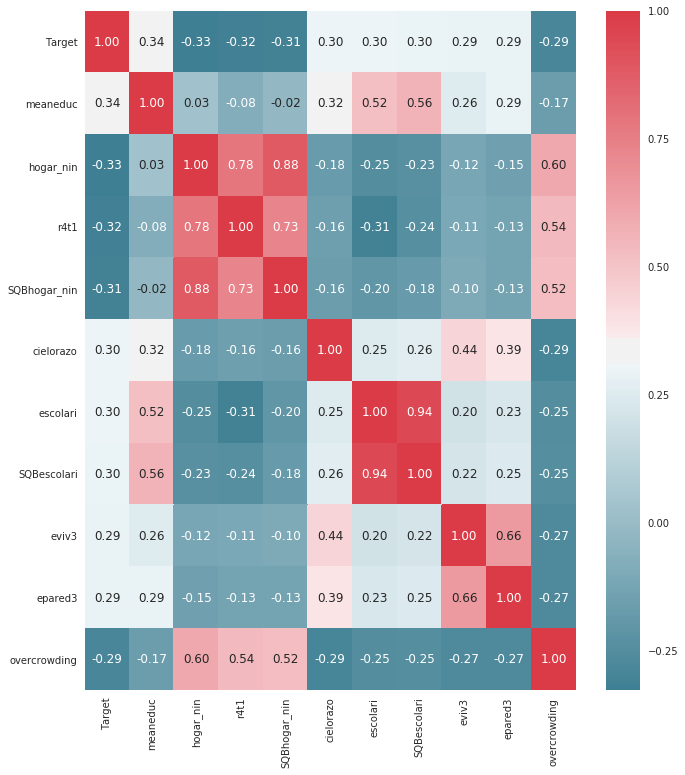

In [9]:
corr = train_df[selected_cols].corr()
sns.set(font_scale=1)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 12.5))
sns.heatmap(corr, cmap=cmap, annot=True, ax=ax, fmt='.2f')

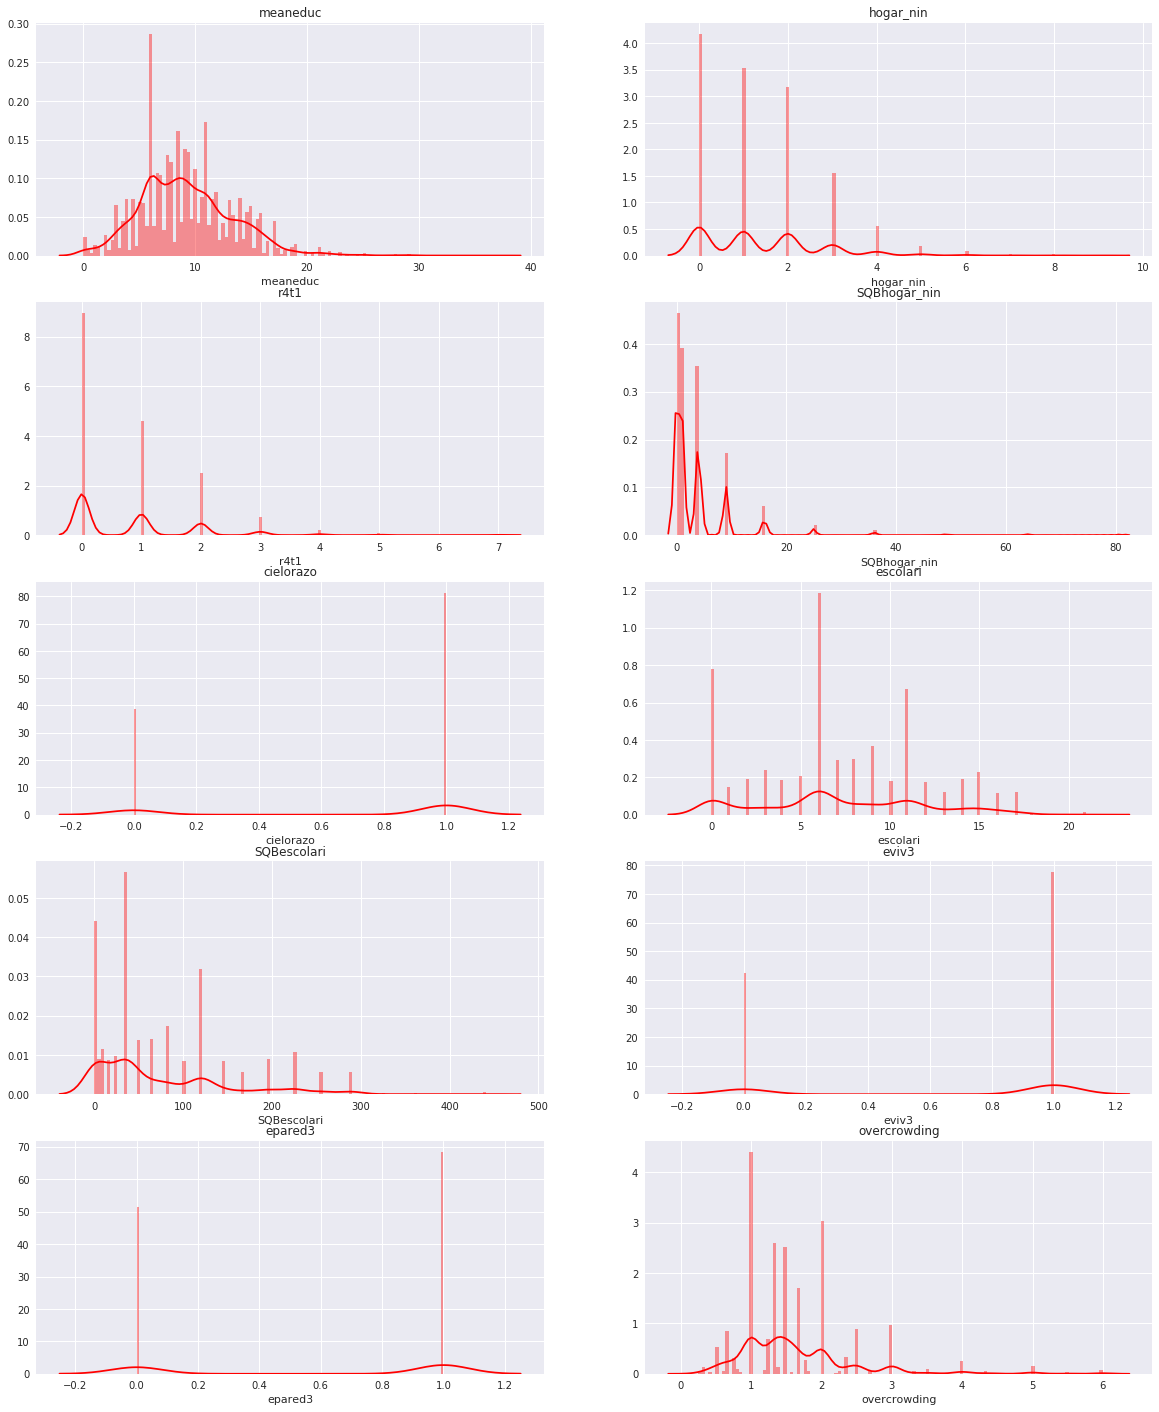

In [13]:
plt.figure(figsize=(20, 30))
for i, col in enumerate(selected_cols[1:]):
    plt.subplot(6, 2, i + 1)
    sns.distplot(train_df[col].dropna(), color="red", kde=True,bins=120)
    plt.title(col)
plt.show()

NameError: name 'train_df' is not defined

In [11]:
test_df = pd.read_csv('../input/test.csv')
test_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324


In [12]:
test_df.shape

(23856, 142)

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


In [14]:
test_df.isnull().values.sum(axis=0)

array([    0, 17403,     0,     0,     0,     0,     0,     0, 18126,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 19653,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,    31,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [15]:
test_df_describe = test_df.describe()
test_df_describe

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,...,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
count,6.453000e+03,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,5730.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,4203.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,...,23856.000000,23825.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.00000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23825.000000,23856.000000
mean,1.748726e+05,0.050679,4.955776,0.028421,0.992748,0.961603,0.240191,1.348517,0.416541,1.563967,1.980508,0.389168,1.656522,2.045691,0.805709,3.220490,4.026199,4.021756,4.140426,7.214914,0.425172,4.021756,0.588741,0.077171,0.201375,0.008300,0.107017,0.014462,0.001677,0.001258,0.692740,0.234029,0.001761,0.000126,0.013456,0.057889,0.971538,0.018989,0.002138,0.001425,...,4.021756,9.157474,0.130449,0.174128,0.208166,0.184775,0.112844,0.017815,0.013875,0.143863,0.013875,2.747108,1.642226,0.625964,0.106346,0.164152,0.018192,0.085345,0.114059,0.289361,0.977825,2.840921,0.580651,0.082746,0.073105,0.086519,0.099640,0.077339,0.721663,0.278337,34.454183,74.44974,1657.798080,19.113389,54.087232,3.885480,3.564751,4.171669,100.509220,1657.798080
std,1.567887e+05,0.219346,1.539753,0.166174,0.084850,0.192157,0.427208,0.694216,0.713255,0.990171,1.171626,0.677171,0.898531,1.170700,1.068370,1.349542,1.714507,1.714350,1.877819,4.732408,1.767765,1.714350,0.492072,0.266869,0.401036,0.090726,0.309141,0.119387,0.040914,0.035440,0.461368,0.423399,0.041923,0.011214,0.115218,0.233538,0.166293,0.136489,0.046188,0.037726,...,1.714350,4.080513,0.336804,0.379228,0.406004,0.388123,0.316408,0.132282,0.116974,0.350958,0.116974,0.969614,0.931602,0.483883,0.308287,0.370421,0.133650,0.279401,0.317890,0.453475,0.147255,1.444383,0.493463,0.275504,0.260315,0.281135,0.299525,0.267134,0.448189,0.448189,21.696245,76.99701,1753.603406,17.314597,77.312255,6.878967,6.668757,13.105989,89.211063,1753.603406
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000
25%,8

The test set is almost 2.5 times larger than the train set. It also has 5 features with missing data.

Now, let's take a look at the target. We want to see the distribution of target values in the train set.

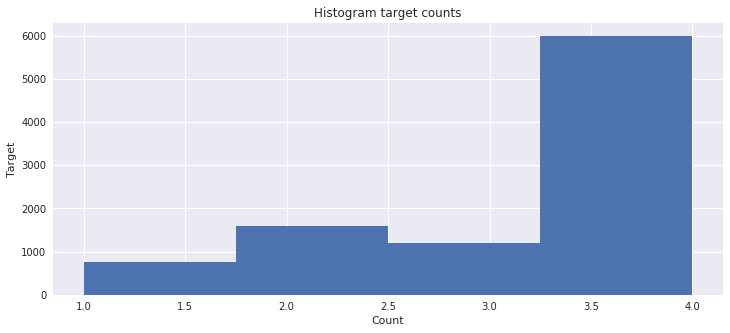

In [16]:
plt.figure(figsize=(12, 5))
plt.hist(train_df.Target.values, bins=4)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

In [17]:
np.unique(train_df.Target.values)

array([1, 2, 3, 4])

We see that there are only 4 numerical values in for the target. Value 4 seems to dominate, with about 60% of all values. 

In [18]:
pd.value_counts(train_df.Target)

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

Now we want to subset the features, so that they don't include Id and target.

In [19]:
columns_to_use = train_df.columns[1:-1]

In [20]:
columns_to_use

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'age', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe',
       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
       'agesq'],
      dtype='object', length=141)

We'll set up the new variable ```y``` that will be our target variable for training.

In [21]:
y = train_df['Target'].values-1

Next, we'll combine the train and test sets, so we can consistenly label encode all the categorical features.

In [22]:
train_test_df = pd.concat([train_df[columns_to_use], test_df[columns_to_use]], axis=0)
cols = [f_ for f_ in train_test_df.columns if train_test_df[f_].dtype == 'object']

for col in cols:
    le = LabelEncoder()
    le.fit(train_test_df[col].astype(str))
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
del le

Now is the time to build our first model. We'll use make a simple LGBM model.

In [23]:
train = lgb.Dataset(train_df[columns_to_use].astype('float'),y ,feature_name = "auto")

In [24]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'max_depth': 5,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': 6,
    'lambda_l2': 1.0,
    'min_gain_to_split': 0,
    'num_class': len(np.unique(y)),
}

In [25]:
clf = lgb.train(params,
        train,
        num_boost_round = 500,
        verbose_eval=True)

In [26]:
preds1 = clf.predict(test_df[columns_to_use])

In [27]:
xgb_params = {
        'learning_rate': 0.1,
        'n_estimators': 1000,
        'max_depth': 5,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 0.9,
        'colsample_bytree': 0.84,
        'objective': 'multi:softprob',
        'scale_pos_weight': 1,
        'eval_metric': 'merror',
        'silent': 1,
        'verbose': False,
        'num_class': 4,
        'seed': 44}
    
d_train = xgb.DMatrix(train_df[columns_to_use].values.astype('float'), y)
d_test = xgb.DMatrix(test_df[columns_to_use].values.astype('float'))
    
model = xgb.train(xgb_params, d_train, num_boost_round = 500, verbose_eval=100)
                        
xgb_pred = model.predict(d_test)

In [25]:
xgb_pred.shape

(23856, 4)

In [26]:
preds = 0.5*preds1 + 0.5*xgb_pred

preds = np.argmax(preds, axis = 1) +1
preds

array([4, 4, 4, ..., 4, 4, 4])

In [27]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
sample_submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [28]:
sample_submission['Target'] = preds
sample_submission.to_csv('simple_lgbm_xgb_1.csv', index=False)
sample_submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [29]:
np.mean(preds)

3.52661804158283

To be continued ...

In [30]:
# Lab 2 & Lab 4

In [31]:
# SHARP
